In [54]:
import os, getpass
from dotenv import load_dotenv

load_dotenv()

True

In [55]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [56]:
from pydantic import BaseModel, Field
from typing import List, Annotated
from typing_extensions import TypedDict
import operator
from typing import  Annotated
from langgraph.graph import MessagesState
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

class CarPart(BaseModel):
    team: str = Field(description="F1 team developing or evaluating the part.")
    name: str = Field(description="Name of the car part component")
    category: str = Field(description="Category of the part (e.g., Aerodynamics, Power Unit, Suspension)")
    focus: str = Field(description="Description of the part's focus, concerns, and strategic motives.")
    @property
    def specification(self) -> str:
        return f"Name: {self.name}\nCategory: {self.category}\nTeam: {self.team}\nFocus: {self.focus}\n"

class DevelopmentTeam(BaseModel):
    parts: List[CarPart] = Field(
        description="Comprehensive list of race parts with their categories and team affiliations.",
    )

class GeneratePartState(TypedDict):
    race_name: str
    max_parts: int
    technical_feedback: str
    parts: List[CarPart]
    


class PartDevelopmentState(TypedDict):
    race_name: str
    max_parts: int
    technical_feedback: str
    parts: List[CarPart]
    strategy_memos: Annotated[list, operator.add]
    technical_briefing: str
    strategy_summary: str
    final_recommendation: str
    final_report: str



class PartSimState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    part: CarPart
    simulation_log: str
    strategy_memos: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [57]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

development_instructions="""You are tasked with creating a set of F1 car part development proposals. Follow these instructions carefully (Use the actual teamnames like Mercedes, McLaren, etc):
1. Review the development project: {race_name}
2. Examine any technical feedback: {technical_feedback}
3. Determine the most promising areas for performance gains.
4. Pick the top {max_parts} development areas.
5. Create one part proposal for each area, specifying the name, category, team, and performance objectives."""

def create_parts(state: GeneratePartState):
    """ Create race parts """

    race_name=state['race_name']
    max_parts=state['max_parts']
    technical_feedback=state.get('technical_feedback', '')

    structured_llm = llm.with_structured_output(DevelopmentTeam)

    system_message = development_instructions.format(race_name=race_name,
                                                            technical_feedback=technical_feedback,
                                                            max_parts=max_parts)

    parts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of race parts.")])

    return {"parts": parts.parts}

def human_feedback(state: GeneratePartState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GeneratePartState):
    """ Return the next node to execute """

    technical_feedback=state.get('technical_feedback', None)
    if technical_feedback:
        return "create_parts"

    return END

builder = StateGraph(GeneratePartState)
builder.add_node("create_parts", create_parts)
builder.add_node("technical_review", human_feedback)
builder.add_edge(START, "create_parts")
builder.add_edge("create_parts", "technical_review")
builder.add_conditional_edges("technical_review", should_continue, ["create_parts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['technical_review'], checkpointer=memory)

In [58]:
question_instructions = """You are a Technical Development Engineer interviewing a CFD/Wind Tunnel Simulation AI to evaluate a new car part.
Your goal is to extract detailed performance data. Focus on specific gains and trade-offs.
Part specification: {specification}
Begin by introducing yourself and ask your first question. When satisfied, say: "Thank you, that's all the data I need." """

def generate_technical_question(state: PartSimState):
    """ Node to generate a strategy question """
    part = state["part"]
    messages = state["messages"]

    system_message = question_instructions.format(specification=part.specification)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    return {"messages": [question]}


tavily_search = TavilySearchResults(max_results=3)

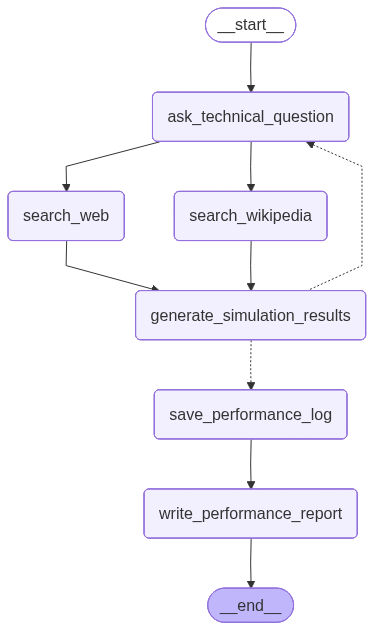

In [59]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content="""Given the conversation, generate a web search query for F1 technical specifications or historical data, focusing on the engineer's last question.""")

def search_web(state: PartSimState):

    """ Retrieve docs from web search (e.g., live weather) """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: PartSimState):

    """ Retrieve docs from wikipedia (e.g., historical track data) """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are a CFD/Wind Tunnel Simulation AI.

To answer the question, use this simulation data and context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_simulation_results(state: PartSimState):

    """ Node to generate a simulation answer """

    part = state["part"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(specification=part.specification, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "simulator"

    return {"messages": [answer]}

def save_performance_log(state: PartSimState):

    """ Save simulation log """

    messages = state["messages"]

    simulation_log = get_buffer_string(messages)

    return {"simulation_log": simulation_log}

def route_messages(state: PartSimState,
                   name: str = "simulator"):

    """ Route simulation conversation """

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        return 'save_performance_log'

    last_question = messages[-2]

    if "Thank you, that's all the data I need." in last_question.content:
        return 'save_performance_log'
    return "ask_technical_question"

section_writer_instructions = """You are an expert strategy analyst.

Your task is to create a short, easily digestible strategy memo based on a set of simulation data and context documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. ## [Strategy Memo Title]
b. ### [Key Insights]
c. ### [Data Sources]

4. Make your title engaging based upon the focus area of the part:
{specification}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the part
- Emphasize what is novel, interesting, or surprising about insights gathered from the simulation debrief
- Create a numbered list of source documents, as you use them
- Do not mention the names of parts or the simulator
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Data Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Data Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_performance_report(state: PartSimState):

    """ Node to write strategy memo """

    simulation_log = state["simulation_log"]
    context = state["context"]
    part = state["part"]

    system_message = section_writer_instructions.format(specification=part.specification)
    memo = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    return {"strategy_memos": [memo.content]}

sim_builder = StateGraph(PartSimState)
sim_builder.add_node("ask_technical_question", generate_technical_question)
sim_builder.add_node("search_web", search_web)
sim_builder.add_node("search_wikipedia", search_wikipedia)
sim_builder.add_node("generate_simulation_results", generate_simulation_results)
sim_builder.add_node("save_performance_log", save_performance_log)
sim_builder.add_node("write_performance_report", write_performance_report)

sim_builder.add_edge(START, "ask_technical_question")
sim_builder.add_edge("ask_technical_question", "search_web")
sim_builder.add_edge("ask_technical_question", "search_wikipedia")
sim_builder.add_edge("search_web", "generate_simulation_results")
sim_builder.add_edge("search_wikipedia", "generate_simulation_results")
sim_builder.add_conditional_edges("generate_simulation_results", route_messages,['ask_technical_question','save_performance_log'])
sim_builder.add_edge("save_performance_log", "write_performance_report")
sim_builder.add_edge("write_performance_report", END)

memory = MemorySaver()
sim_graph = sim_builder.compile(checkpointer=memory).with_config(run_name="Conduct Simulation Debrief")

display(Image(sim_graph.get_graph().draw_mermaid_png()))

C:\Users\harsi\AppData\Local\Temp\ipykernel_16944\1663979990.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


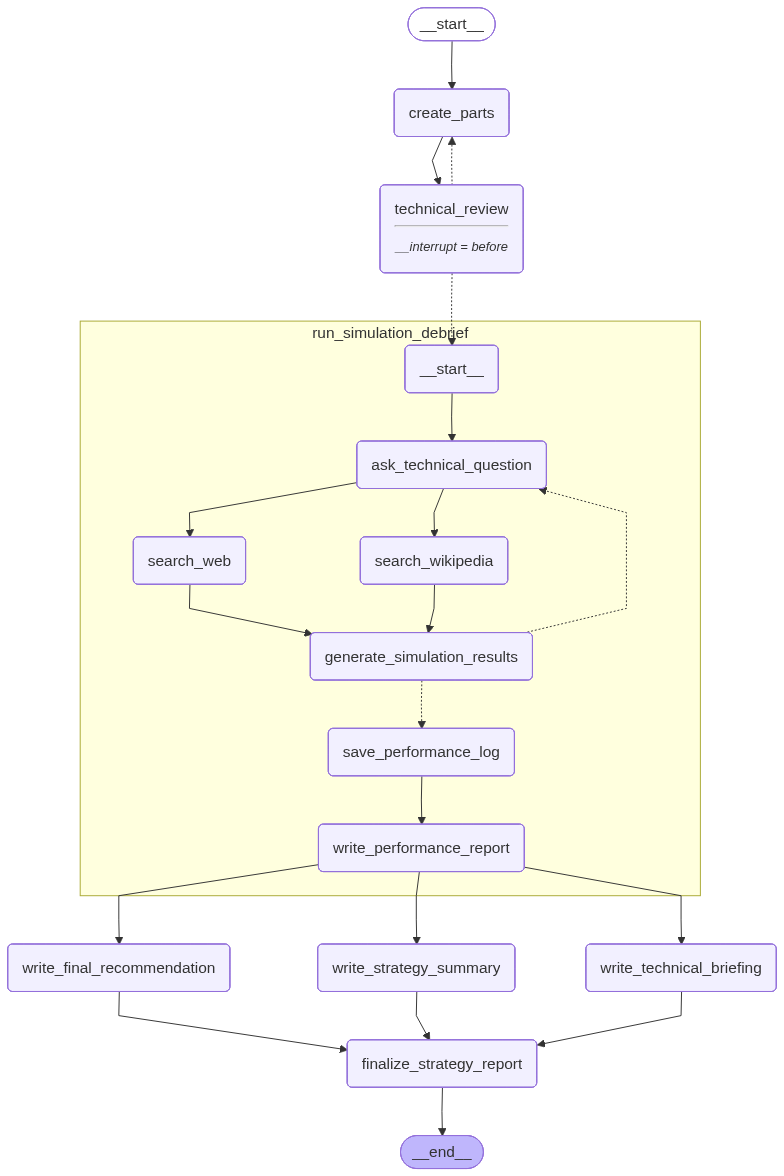

In [60]:
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

def initiate_all_simulations(state: PartDevelopmentState):
    """ This is the "map" step where we run each simulation sub-graph using Send API """

    technical_feedback=state.get('technical_feedback')
    if technical_feedback:
        return "create_parts"

    else:
        race_name = state["race_name"]
        return [Send("run_simulation_debrief", {"part": part,
                                           "messages": [HumanMessage(
                                               content=f"Let's start the simulation debrief for {race_name}."
                                           )
                                                       ]}) for part in state["parts"]]

report_writer_instructions = """You are a Lead Engineer creating a summary report for {race_name}

You have a list of race parts. Each part has done two things:

1. They conducted an simulation debrief with an expert on a specific sub-topic.
2. They written up their findings into a strategy memo.

Your task:

1. You will be given a collection of memos from your parts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Strategy Summary
5. Do not mention any part names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Data Sources section with the `## Data Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the strategy memos from your parts to build your report from:

{context}"""

def write_strategy_summary(state: PartDevelopmentState):
    memos = state["strategy_memos"]
    race_name = state["race_name"]

    formatted_str_memos = "\n\n".join([f"{memo}" for memo in memos])

    system_message = report_writer_instructions.format(race_name=race_name, context=formatted_str_memos)
    summary = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"strategy_summary": summary.content}

intro_conclusion_instructions = """You are a Lead Engineer writing a briefing for the {race_name}

You will be given all of the strategy memos.

You job is to write a crisp and compelling pre-race briefing (introduction) or a final recommendation (conclusion) section.

The user will instruct you whether to write the briefing or recommendation.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for briefing) or recapping (for recommendation) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_technical_briefing(state: PartDevelopmentState):
    memos = state["strategy_memos"]
    race_name = state["race_name"]

    formatted_str_memos = "\n\n".join([f"{memo}" for memo in memos])

    instructions = intro_conclusion_instructions.format(race_name=race_name, formatted_str_sections=formatted_str_memos)
    briefing = llm.invoke([instructions]+[HumanMessage(content=f"Write the technical briefing")])
    return {"technical_briefing": briefing.content}

def write_final_recommendation(state: PartDevelopmentState):
    memos = state["strategy_memos"]
    race_name = state["race_name"]

    formatted_str_memos = "\n\n".join([f"{memo}" for memo in memos])

    instructions = intro_conclusion_instructions.format(race_name=race_name, formatted_str_sections=formatted_str_memos)
    recommendation = llm.invoke([instructions]+[HumanMessage(content=f"Write the final recommendation")])
    return {"final_recommendation": recommendation.content}

def finalize_strategy_report(state: PartDevelopmentState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    summary = state["strategy_summary"]
    if summary.startswith("## Strategy Summary"):
        summary = summary.strip("## Strategy Summary")
    if "## Data Sources" in summary:
        try:
            summary, sources = summary.split("\n## Data Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["technical_briefing"] + "\n\n---\n\n" + summary + "\n\n---\n\n" + state["final_recommendation"]
    if sources is not None:
        final_report += "\n\n## Data Sources\n" + sources
    return {"final_report": final_report}

builder = StateGraph(PartDevelopmentState)
builder.add_node("create_parts", create_parts)
builder.add_node("technical_review", human_feedback)
builder.add_node("run_simulation_debrief", sim_graph) # <-- This is the corrected line
builder.add_node("write_strategy_summary",write_strategy_summary)
builder.add_node("write_technical_briefing",write_technical_briefing)
builder.add_node("write_final_recommendation",write_final_recommendation)
builder.add_node("finalize_strategy_report",finalize_strategy_report)

builder.add_edge(START, "create_parts")
builder.add_edge("create_parts", "technical_review")
builder.add_conditional_edges("technical_review", initiate_all_simulations, ["create_parts", "run_simulation_debrief"])
builder.add_edge("run_simulation_debrief", "write_strategy_summary")
builder.add_edge("run_simulation_debrief", "write_technical_briefing")
builder.add_edge("run_simulation_debrief", "write_final_recommendation")
builder.add_edge(["write_final_recommendation", "write_strategy_summary", "write_technical_briefing"], "finalize_strategy_report")
builder.add_edge("finalize_strategy_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['technical_review'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [70]:
max_parts = 8
race_name = "Silverstone 2025 GP"
thread = {"configurable": {"thread_id": "Part_Development1"}}

for event in graph.stream({"race_name":race_name,
                           "max_parts":max_parts},
                          thread,
                          stream_mode="values"):

    parts = event.get('parts', '')
    if parts:
        for part in parts:
            print(f"Name: {part.name}")
            print(f"Team: {part.team}")
            print(f"Category: {part.category}")
            print(f"Focus: {part.focus}")
            print("-" * 50)

Name: Front Wing Upgrade
Team: Mercedes
Category: Aerodynamics
Focus: Enhance downforce and reduce drag to improve cornering speed and overall lap times.
--------------------------------------------------
Name: Hybrid Power Unit Optimization
Team: Red Bull
Category: Power Unit
Focus: Increase energy recovery efficiency and boost power output for better acceleration and top speed.
--------------------------------------------------
Name: Rear Suspension Revision
Team: McLaren
Category: Suspension
Focus: Improve rear grip and stability during high-speed cornering to enhance handling.
--------------------------------------------------
Name: Cooling System Enhancement
Team: Ferrari
Category: Thermal Management
Focus: Optimize cooling to maintain performance consistency and prevent overheating during race conditions.
--------------------------------------------------
Name: Transmission System Upgrade
Team: Alpine
Category: Drivetrain
Focus: Reduce shift times and improve power delivery smoot

In [71]:
graph.update_state(thread, {"technical_feedback":
                                "Look into the MGU-K idea. Let's also explore a lightweight brake system specifically for Britain's heavy braking zones."}, as_node="technical_review")

{'configurable': {'thread_id': 'Part_Development1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6edc-8c76-617f-8002-94e1fb82e43a'}}

In [72]:
for event in graph.stream(None, thread, stream_mode="values"):
    parts = event.get('parts', '')
    if parts:
        for part in parts:
            print(f"Name: {part.name}")
            print(f"Team: {part.team}")
            print(f"Category: {part.category}")
            print(f"Focus: {part.focus}")
            print("-" * 50)

Name: Front Wing Upgrade
Team: Mercedes
Category: Aerodynamics
Focus: Enhance downforce and reduce drag to improve cornering speed and overall lap times.
--------------------------------------------------
Name: Hybrid Power Unit Optimization
Team: Red Bull
Category: Power Unit
Focus: Increase energy recovery efficiency and boost power output for better acceleration and top speed.
--------------------------------------------------
Name: Rear Suspension Revision
Team: McLaren
Category: Suspension
Focus: Improve rear grip and stability during high-speed cornering to enhance handling.
--------------------------------------------------
Name: Cooling System Enhancement
Team: Ferrari
Category: Thermal Management
Focus: Optimize cooling to maintain performance consistency and prevent overheating during race conditions.
--------------------------------------------------
Name: Transmission System Upgrade
Team: Alpine
Category: Drivetrain
Focus: Reduce shift times and improve power delivery smoot

In [73]:
graph.update_state(thread, {"technical_feedback":
                            None}, as_node="technical_review")

{'configurable': {'thread_id': 'Part_Development1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6edc-c9f9-644b-8004-dd25a3fe5603'}}

In [74]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
run_simulation_debrief
--Node--
write_final_recommendation
--Node--
write_technical_briefing
--Node--
write_strategy_summary
--Node--
finalize_strategy_report


In [75]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Silverstone 2025 GP: Technical Briefing

## Introduction

This briefing synthesizes key technical insights from the strategy memos, focusing on power unit efficiency, aerodynamic optimization, suspension tuning, cooling strategies, weight reduction, and telemetry enhancements. Silverstone’s high-speed layout demands a balanced approach—maximizing hybrid system responsiveness, aerodynamic downforce, and mechanical stability—while managing thermal loads and weight constraints. The integration of incremental upgrades, adaptive systems, and advanced data analysis is critical to achieving optimal performance. This comprehensive overview provides the technical foundation for strategic decision-making, ensuring the team leverages all innovations to excel at this demanding circuit.

## Power Unit & Hybrid System

Maximize MGU-K efficiency and responsiveness, leveraging simulation data showing >50% thermal efficiency. Fine-tune hybrid control algorithms for high-demand sectors, especially braking zones. Maintain turbo stability via MGU-H heat recovery, crucial under variable weather conditions.

## Aerodynamics

Adopt a medium-downforce rear wing with adjustable profiles, balancing grip and top speed. Implement flexible front wing setups with reduced flap profiles for high-speed stability and precise steering response. Ensure aerodynamic components remain flat and stable during rapid directional changes.

## Suspension & Tire Management

Optimize suspension for neutral camber and precise toe settings to improve tire contact and temperature regulation. Fine-tune load distribution to mitigate tire wear and overheating, especially in high lateral load sections. Calibrate dampers for high stiffness to enhance handling and stability.

## Cooling Strategy

Implement adaptive cooling systems responsive to weather fluctuations, maintaining optimal power unit temperatures. Use high-stiffness radiators and ducts to ensure high-speed stability and effective heat dissipation, especially during intermittent rain.

## Weight Reduction

Target structural and chassis components for weight savings, focusing on materials that preserve safety and aerodynamic performance. Strategic weight placement enhances acceleration, braking, and handling, critical for Silverstone’s high-speed sectors.

## Telemetry & Data Analysis

Leverage high-volume, real-time telemetry to monitor tire temperatures, lateral G-forces, and aerodynamic loads. Integrate environmental sensors for predictive adjustments, enabling proactive setup and race strategy adaptations.

---

This technical overview underpins our strategic approach, ensuring all systems are optimized for Silverstone’s unique demands and maximizing our competitive edge.

---



The Silverstone 2025 Grand Prix presented a complex challenge that required a multifaceted approach to optimize performance across various vehicle systems and configurations. The high-speed, demanding layout with fast corners, long straights, and significant lateral loads necessitated a finely tuned hybrid power unit, aerodynamic setup, suspension, cooling, braking, and telemetry strategies.

Central to the power unit strategy was maximizing hybrid efficiency, particularly the MGU-K system, which is critical for energy recovery and deployment during Silverstone’s high-demand sectors. Simulation data indicates that the 2025 power units have achieved over 50% thermal efficiency, enabling more effective fuel-to-power conversion. Incremental upgrades, such as turbocharger tuning and control system refinements, have enhanced responsiveness without requiring major package changes. These improvements, combined with aerodynamic and suspension integration, are expected to deliver increased energy recovery, power output, and reliability, especially under Silverstone’s high-speed and variable weather conditions.

The circuit’s high-speed profile also influences aerodynamic choices. A medium-downforce rear wing configuration, featuring a versatile spoon-shaped element, offers a balanced approach—providing sufficient rear grip for fast corners while minimizing drag on straights. Teams are employing adaptable setups, switching between high- and low-downforce configurations based on track conditions, to optimize lap times and stability. Front wing modifications, such as reducing flap profiles and integrating floor aerodynamics, further enhance front-end grip and steering response, crucial for navigating Silverstone’s technical corners with precision.

Suspension tuning remains vital for managing tire wear and temperature, given the lateral loads and high speeds. A balanced setup with neutral camber, precise toe angles, and optimized load distribution helps mitigate tire degradation and overheating, ensuring consistent grip throughout the race. Complementary aerodynamic and floor modifications improve mechanical grip and stability, especially during rapid directional changes.

Cooling strategies have been adapted to Silverstone’s thermal environment, with advanced, weather-responsive systems designed to prevent overheating without increasing drag. Maintaining high stiffness in cooling components and ensuring aerodynamic stability through a flat platform design are key to managing heat during sustained high-speed sections and intermittent rain, which can affect traction and energy recovery.

Telemetry data collection and analysis have become increasingly sophisticated, with high-volume data streams enabling real-time insights into tire temperatures, lateral G-forces, aerodynamic loads, and environmental conditions. This comprehensive data approach allows teams to fine-tune setups dynamically, optimize tire management, and make informed race decisions, providing a competitive edge in this technically demanding environment.

Overall, the strategic focus at Silverstone 2025 has been on incremental, targeted upgrades across powertrain, aerodynamics, suspension, cooling, and data systems. The integration of these elements—driven by simulation insights and real-time telemetry—aims to maximize speed, stability, and reliability. This holistic approach positions teams to excel in Silverstone’s challenging conditions, ultimately supporting a race strategy centered on efficiency, adaptability, and precision.


---

# Final Recommendation

To maximize performance at Silverstone 2025, we recommend deploying a versatile medium-downforce rear wing with adjustable elements, enabling rapid adaptation between high- and low-downforce setups based on track conditions. Focus on refining the hybrid MGU-K system to enhance energy recovery and responsiveness, leveraging incremental control system improvements. Implement a lightweight brake system tailored to Silverstone’s minimal thermal stress, emphasizing material efficiency without compromising cooling. Optimize suspension settings with neutral camber and precise toe angles to improve tire management and handling through high-speed corners. Lastly, invest in advanced telemetry infrastructure to enable real-time data analysis, supporting proactive strategy adjustments and ensuring consistent race performance.

## Data Sources

1. https://scuderiafans.com/silverstone-2025-f1-preview-the-ideal-setup-for-speed-efficiency-and-cornering-stability/  
2. https://en.wikipedia.org/wiki/2025_British_Grand_Prix  
3. https://www.mclaren.com/racing/formula-1/2025/mcl39-technical-specification/  
4. https://www.linkedin.com/pulse/2025-formula-1-grand-prix-technologies-comprehensive-mogilevsky-f4mbc